In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree
from german_holidays import get_german_holiday_calendar
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10') # for graph stying

In [2]:
#Read the dataset
main_df = pd.read_excel('SalesData.xlsx', parse_dates=True)
main_df.head()


#Then group the data by the date
main_df['From'] = pd.to_datetime(main_df['From']).dt.date
main_df = pd.DataFrame(main_df.groupby(main_df['From'])['Sold Units'].sum())
main_df.head()

,Sold Units
From,
2013-01-01,2319
2013-01-02,25179
2013-01-03,26097
2013-01-04,25737
2013-01-05,11385


In [3]:
main_df.describe()

,Sold Units
count,2463.000000
mean,10162.772229
std,6508.027061
min,681.000000
25%,5859.000000
50%,8733.000000
75%,12093.000000
max,30753.000000


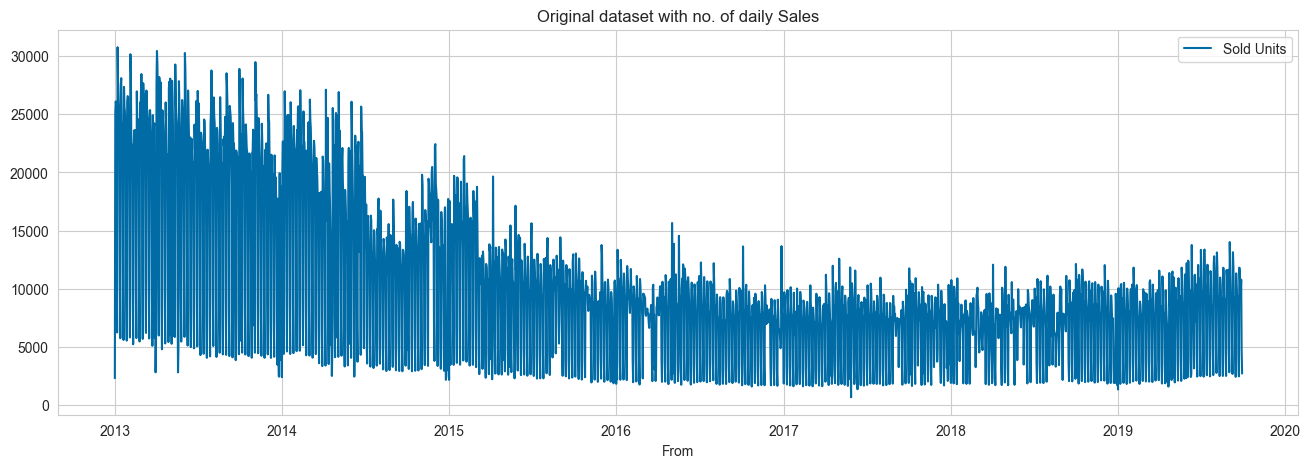

In [4]:
main_df.plot(figsize=(16,5))
plt.title('Original dataset with no. of daily Sales')
plt.show()

In [5]:
# Importing German holidays
cal_cls = get_german_holiday_calendar('NW')
cal = cal_cls()
holidays = [
 h.date() for h in pd.to_datetime(cal.holidays(start='2012', end='2020'))
]
training_df = main_df.groupby(['From'])['Sold Units'].sum().reset_index()
training_df['Date'] = pd.to_datetime(training_df['From']).dt.date
training_df = training_df[training_df['Date'].isin(holidays) == False]
training_df['From'] = pd.to_datetime(training_df['From'])

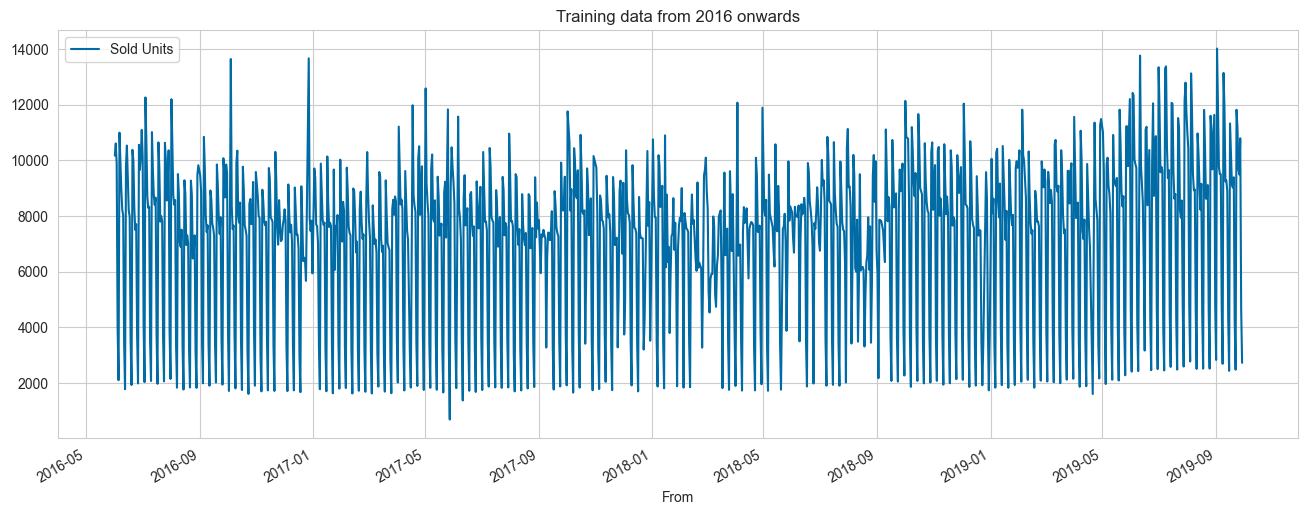

In [6]:
training_df.set_index('From', inplace=True)
training_df = training_df['2016.06.01':]
training_df.plot(figsize=(16,6))
plt.title('Training data from 2016 onwards')
plt.show()

In [7]:
training_df.describe()

,Sold Units
count,1182.000000
mean,7136.662437
std,2905.343154
min,681.000000
25%,4471.500000
50%,7834.500000
75%,9164.250000
max,14013.000000


In [8]:
# Setting features for the XGBoost
training_df['Year'] = pd.to_datetime(training_df['Date']).dt.year
training_df['Week'] = pd.to_datetime(training_df['Date']).dt.strftime('%U')
training_df['Day'] = pd.to_datetime(training_df['Date']).dt.day
training_df['WeekDay'] = pd.to_datetime(training_df['Date']).dt.dayofweek
training_df['Weekend'] = training_df.WeekDay.isin([5, 6]).astype(int)
training_df.drop(columns='Date', inplace=True) 
training_df.head()

,Sold Units,Year,Week,Day,WeekDay,Weekend
From,,,,,,
2016-06-01,10167,2016,22,1,2,0
2016-06-02,10605,2016,22,2,3,0
2016-06-03,9870,2016,22,3,4,0
2016-06-04,3954,2016,22,4,5,1
2016-06-05,2094,2016,23,5,6,1


In [9]:
training_df.corr()

,Sold Units,Year,Week,Day,WeekDay,Weekend
Sold Units,1.000000,0.101280,0.006098,-0.022159,-0.814640,-0.871099
Year,0.101280,1.000000,-0.361558,-0.006256,-0.000331,0.004909
Week,0.006098,-0.361558,1.000000,0.089013,0.009952,0.010361
Day,-0.022159,-0.006256,0.089013,1.000000,-0.013101,-0.007120
WeekDay,-0.814640,-0.000331,0.009952,-0.013101,1.000000,0.792363
Weekend,-0.871099,0.004909,0.010361,-0.007120,0.792363,1.000000


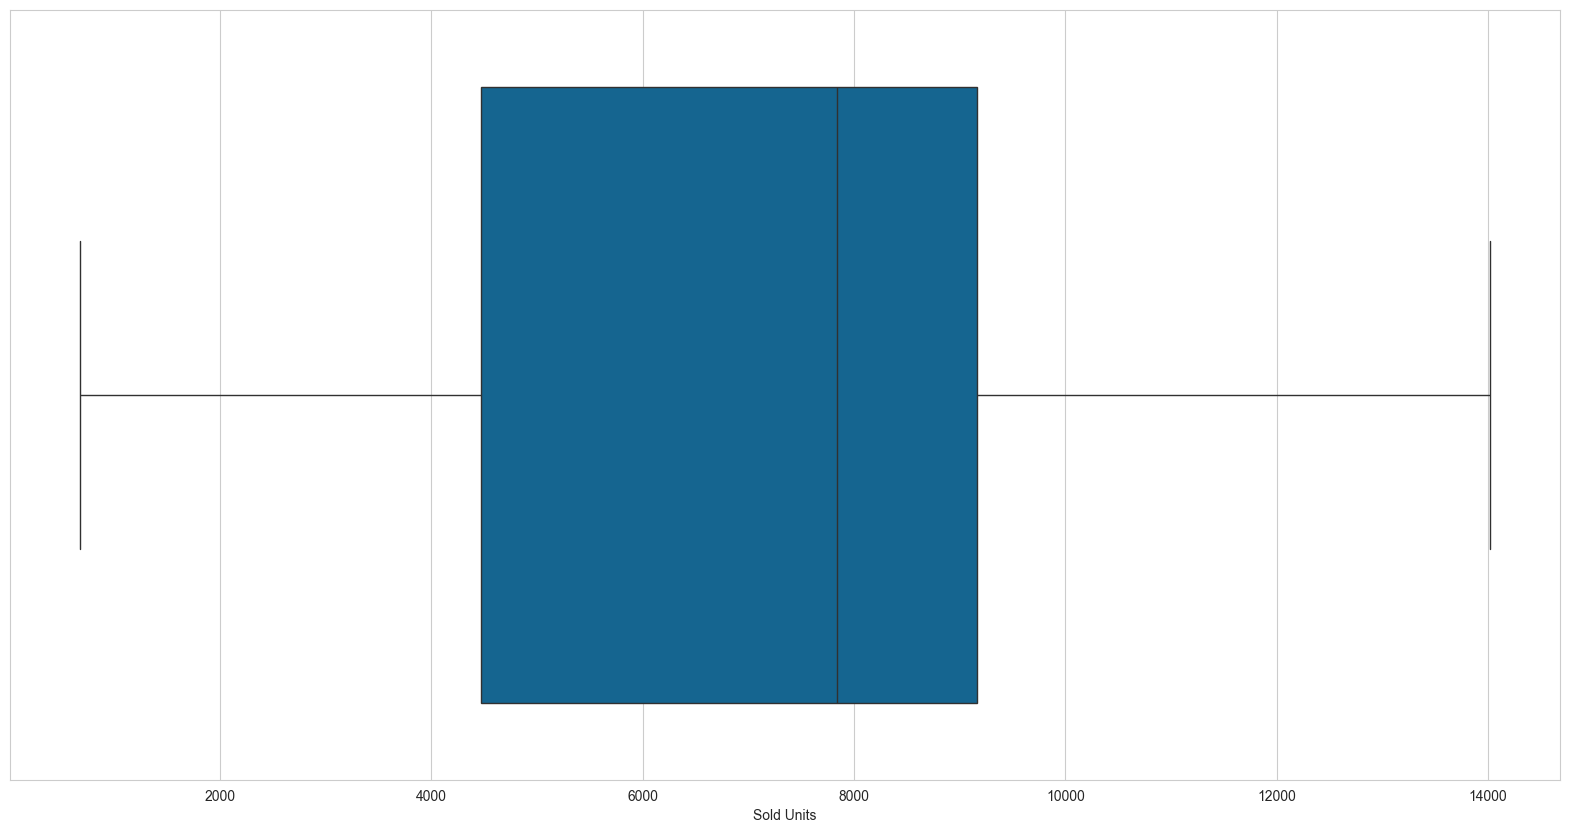

In [10]:
sns.boxplot(x=training_df['Sold Units'])
plt.show()

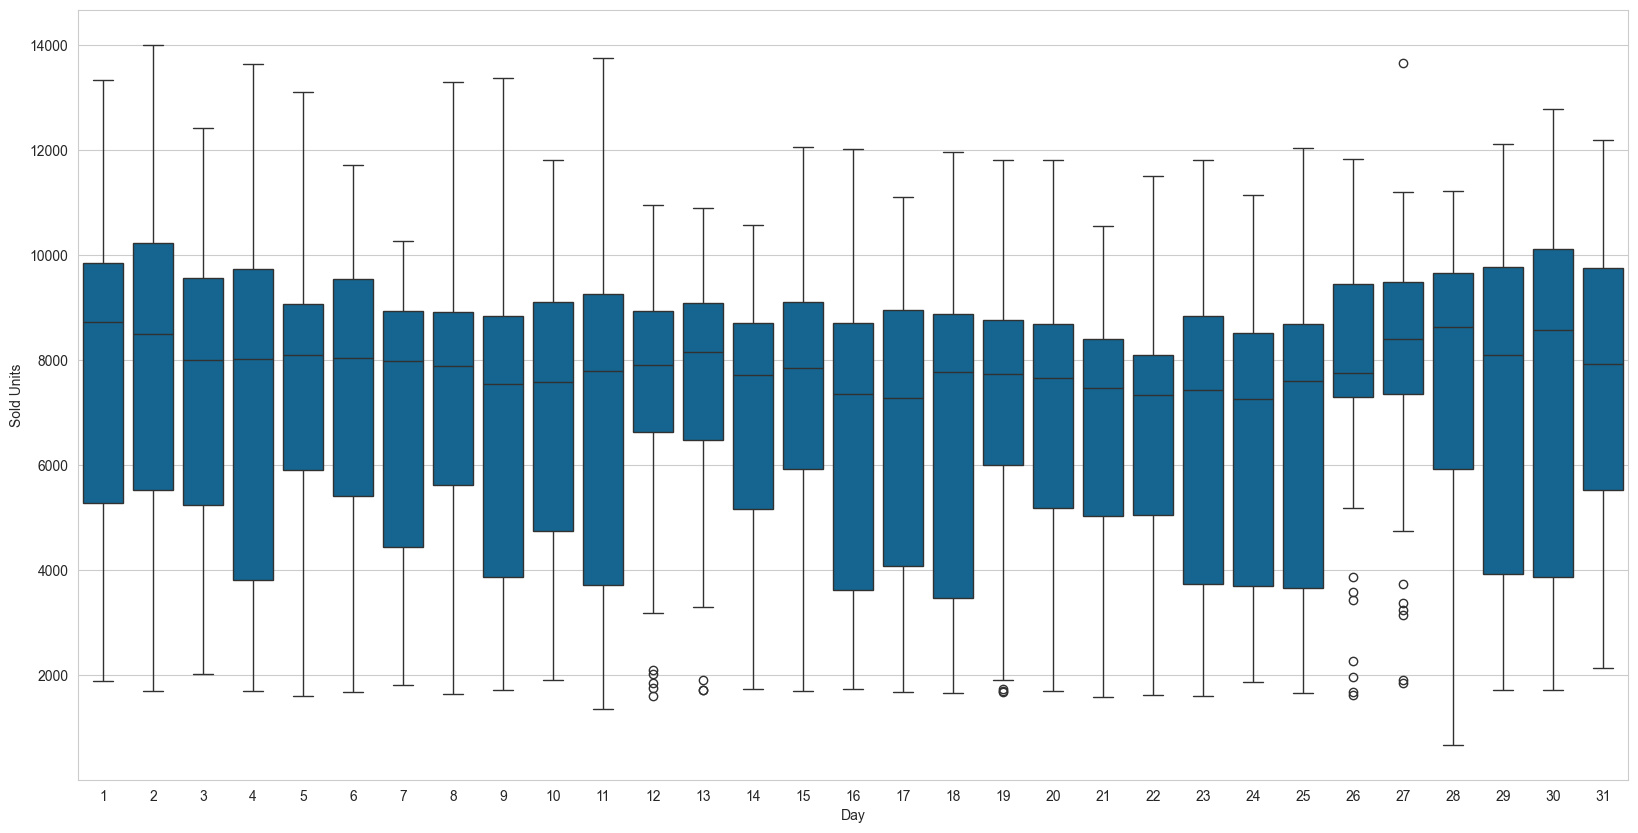

In [11]:
sns.boxplot(x=training_df['Day'], y=training_df['Sold Units'])
plt.show()

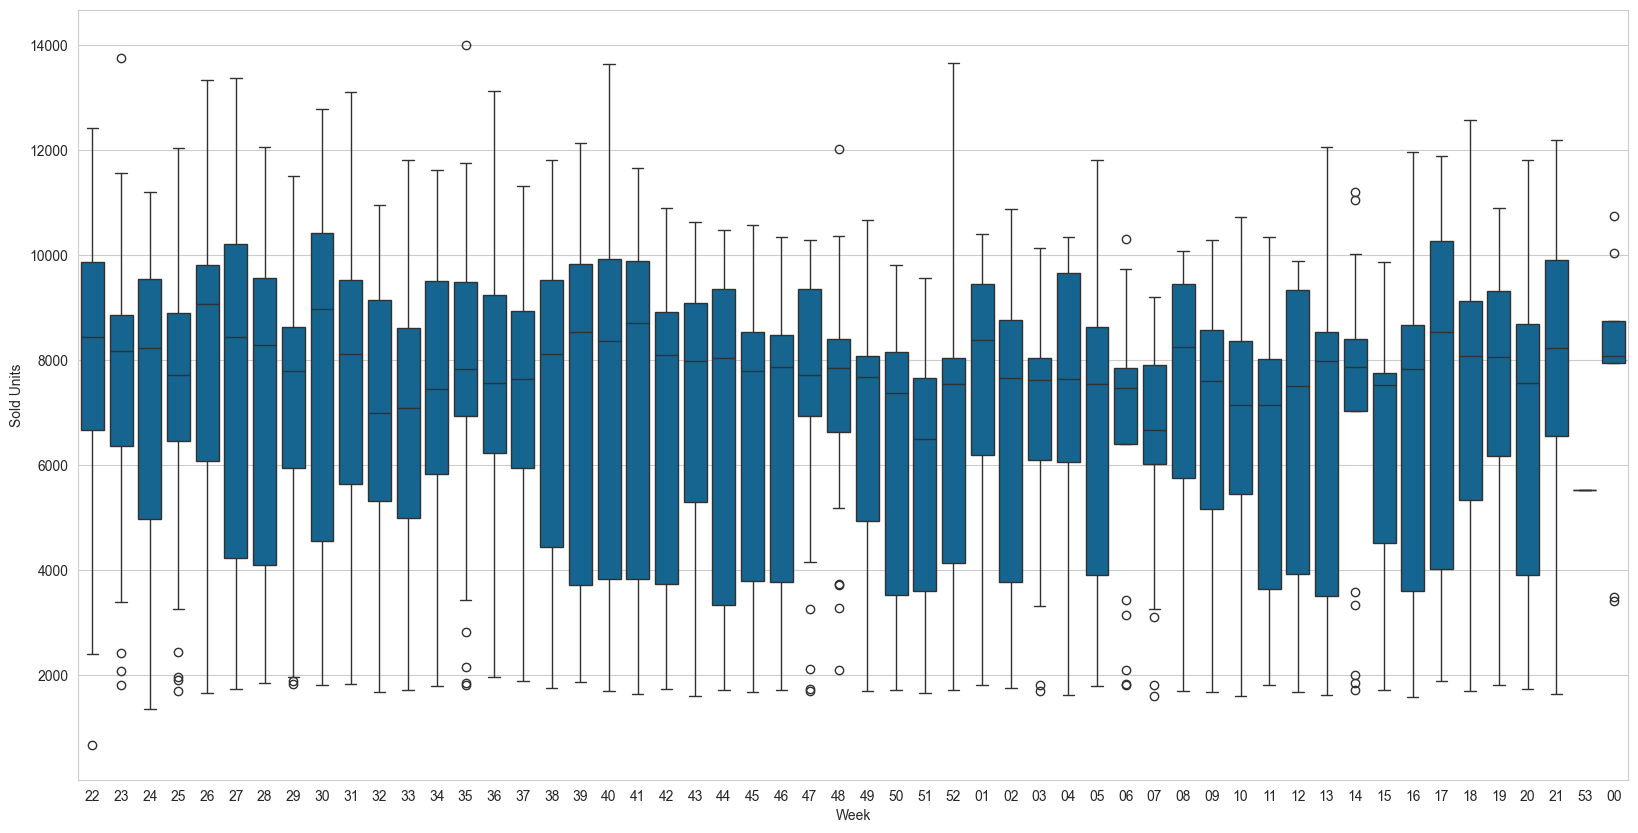

In [12]:
sns.boxplot(x=training_df['Week'], y=training_df['Sold Units'])
plt.show()

In [13]:
training_df = training_df[training_df['Sold Units'] < 14000]
training_df = training_df[training_df['Sold Units'] > 1600]
print(training_df.dtypes)
print(training_df.size)
training_df.head()

Sold Units     int64
Year           int32
Week          object
Day            int32
WeekDay        int32
Weekend        int64
dtype: object
7068


,Sold Units,Year,Week,Day,WeekDay,Weekend
From,,,,,,
2016-06-01,10167,2016,22,1,2,0
2016-06-02,10605,2016,22,2,3,0
2016-06-03,9870,2016,22,3,4,0
2016-06-04,3954,2016,22,4,5,1
2016-06-05,2094,2016,23,5,6,1


In [14]:
split_date = '2019.09.01'
df_train = training_df.loc[training_df.index <= split_date].copy()
df_test = training_df.loc[training_df.index > split_date].copy()

In [15]:
def create_features(df, label=None):
 df['date'] = df.index
 df['hour'] = df['date'].dt.hour
 df['dayofweek'] = df['date'].dt.dayofweek
 df['quarter'] = df['date'].dt.quarter
 df['month'] = df['date'].dt.month
 df['year'] = df['date'].dt.year
 df['dayofyear'] = df['date'].dt.dayofyear
 df['dayofmonth'] = df['date'].dt.day
 df['weekofyear'] = df['date'].dt.strftime('%U').astype(int)
 X = df[[
 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
 'dayofmonth', 'weekofyear'
 ]]
 if label:
  y = df[label]
  return X, y
 return X
X_train, y_train = create_features(df_train, label='Sold Units')
X_test, y_test = create_features(df_test, label='Sold Units')

In [16]:
# A parameter grid for XGBoost
params = {
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}
# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')
grid = GridSearchCV(xgb_reg, params)
grid.fit(X_train, y_train)
gridcv_xgb = grid.best_estimator_
print(r2_score(y_test, gridcv_xgb.predict(X_test)))

0.9790863425300018


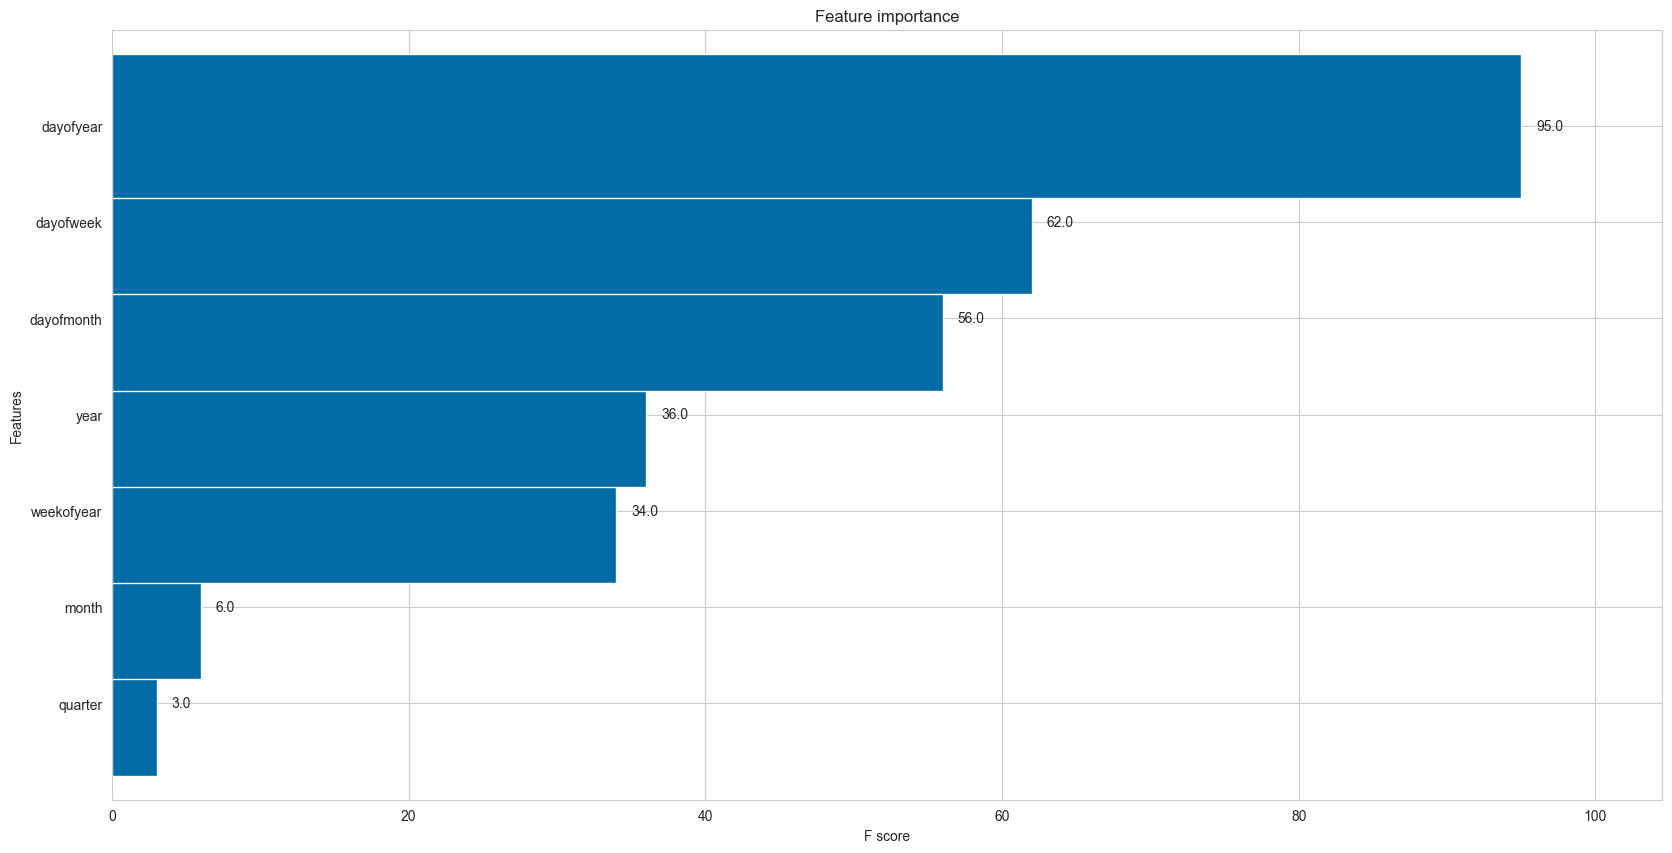

In [17]:
_ = plot_importance(gridcv_xgb, height=1.5)

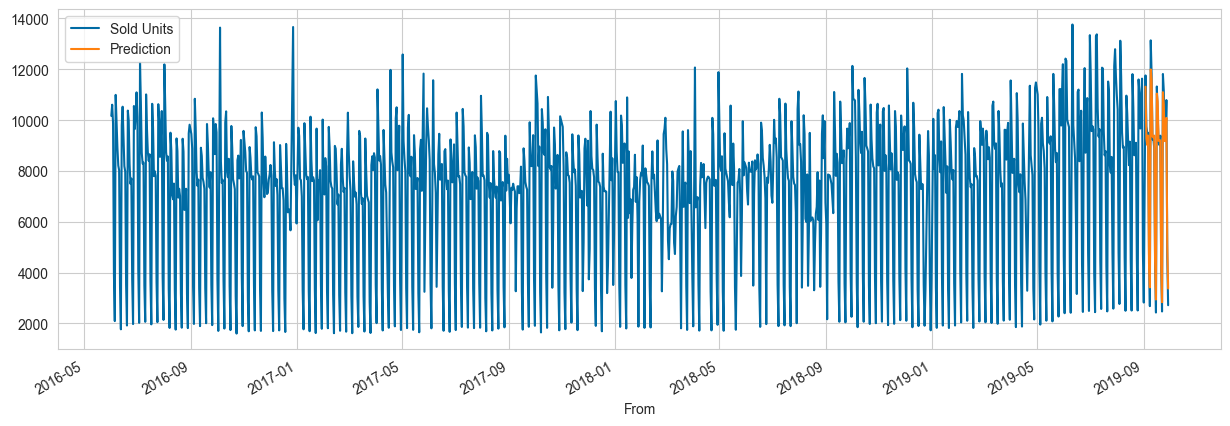

In [18]:
df_test['Prediction'] = gridcv_xgb.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)
_ = df_all[['Sold Units','Prediction']].plot(figsize=(15, 5))

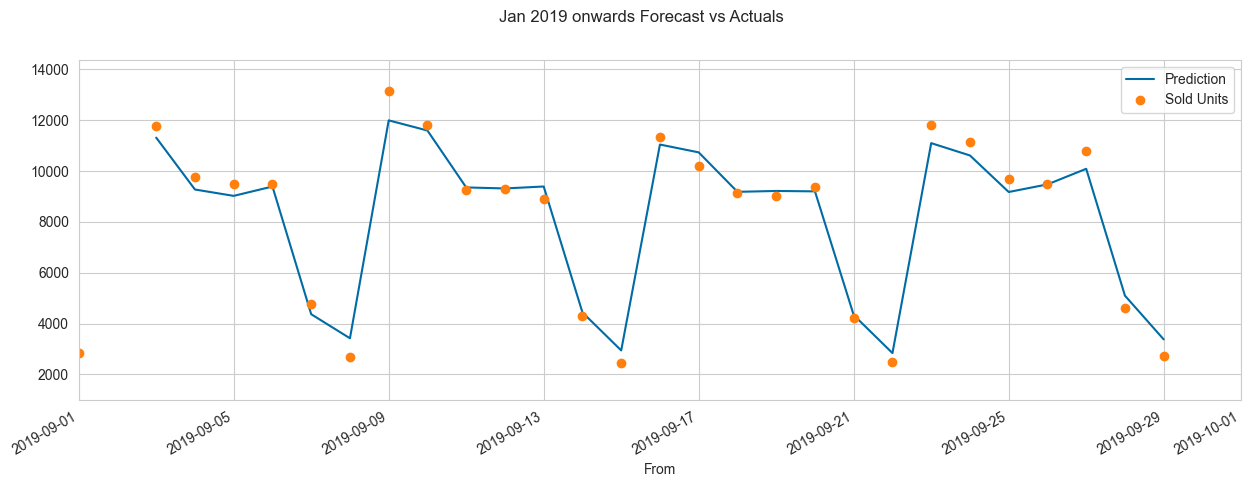

In [19]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['Prediction','Sold Units']].plot(ax=ax, style=['-','o'])
ax.set_xbound(lower='2019.09.01', upper='2019.10.01')
plot = plt.suptitle('Jan 2019 onwards Forecast vs Actuals')

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
 '''Calculates MAPE given y_true and y_pred'''
 y_true, y_pred = np.array(y_true), np.array(y_pred)
 return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(y_true=df_test['Sold Units'],
                   y_pred=df_test['Prediction'])

6.65450970286124

In [21]:
test = pd.read_excel('predictionempty.xlsx', parse_dates=[0], index_col=[0])
pred_x, pred_y = create_features(test, label='Sales')
test['xgb_Prediction'] = gridcv_xgb.predict(pred_x)
test.drop(['Sales','hour','dayofweek', 'quarter', 'month', 'year', 'dayofyear',
 'dayofmonth', 'weekofyear', 'date'], axis=1, inplace=True)
test.head()

,xgb_Prediction
Date,
2019-09-30,12231.708984
2019-10-01,12399.306641
2019-10-02,10653.164062
2019-10-03,10380.751953
2019-10-04,10627.446289


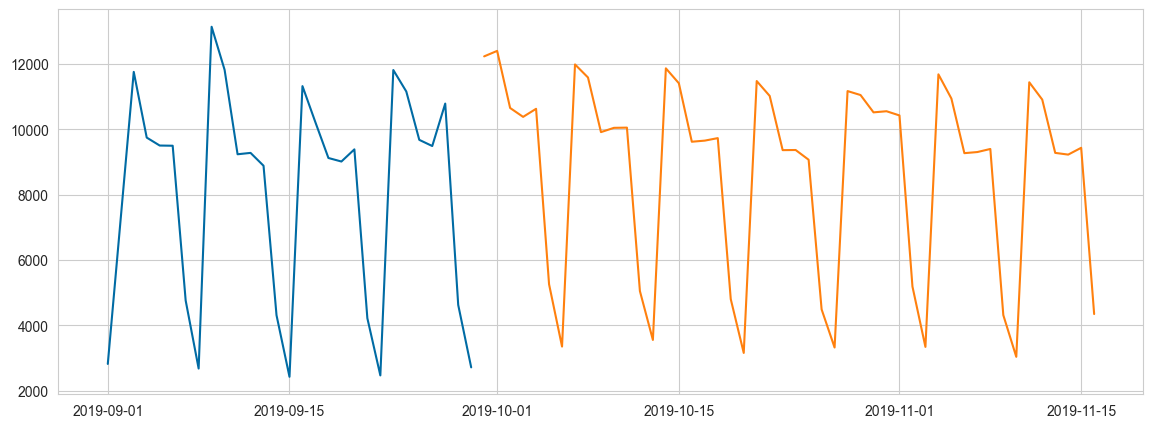

In [22]:
plt.figure(figsize=(14,5))
plt.plot(training_df['Sold Units']['2019.09.01':])
plt.plot(test.xgb_Prediction)
plt.show()

In [23]:
test.to_excel('Prediction.xlsx')